In [1]:
import cvxpy as cp
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import dia_matrix

# Schur stability and Distributed cotrol 

$$
\begin{aligned}
x(t + 1) &= A x(t) + B u(t), \\
x(0) &= x_0
\end{aligned}
$$

For the linear system given above, the system without input ($u(t) = 0$)

$$
x(t+1) = A x(t)
$$

can exhibit either **stable** behavior ($x(t) \to 0$ as $t \to \infty \ \forall \ x_0$) or **unstable** behavior ($x(t) \to \infty$ as $t \to \infty$), depending on the eigenvalues of $A$.

The system is **asymptotically stable** if and only if all eigenvalues of $A$ lie strictly inside the unit circle in the complex plane, i.e.,

$$
|\lambda_i| < 1 \quad \text{for all eigenvalues } \lambda_i \text{ of } A.
$$

The matrix A is called **Schur stable**.
If the system is not Schur stable, feedback control $ u = Kx$ can be designed such that the final system is Schur stable i.e 
$$x(t+1) = (A+BK)x(t)$$
by solving a linear matrix inequality (LMI) using semidefinite programming.

A sufficient condition for Schur stability is the existence of a symmetric positive definite matrix $P \succ 0$ such that:

$$
(A + BK)^T P (A + BK) - P \prec 0
$$

This condition ensures that the closed-loop system has a **quadratic Lyapunov function** $V(x) = x^T P x$ that decreases over time.

To formulate this as a convex problem, we apply a change of variables: define $Y = KQ$ and $Q = P^{-1}$. Then the LMI becomes:

$$
\begin{bmatrix}
Q & (AQ + BY)^T \\
AQ + BY & Q
\end{bmatrix} \succ 0, \quad Q \succ 0
$$

Solving this semidefinite program over variables $X \succ 0$ and $Y$ yields the controller gain as:

$$
K = Y Q^{-1}
$$


In [2]:
mat = scipy.io.loadmat('Matrices.mat')
data = mat['Data']

In [3]:
A = np.array([[0.71, 0.17, 0.20, 0.99, 0.92,],
[0.50, 0.28, 0.62, 0.05, 0.49],
[0.43, 0.59, 0.75, 0.04, 0.79],
[0.19, 0.60, 0.10, 0.43, 0.08],
[0.20, 0.98, 0.62, 0.14, 0.29]])

B = np.array([[0.74, 0.57],
[0.63, 0.91],
[0.21, 0.37],
[0.80, 0.76],
[0.89, 0.40]])

tol = 1e-6

In [4]:
def stabilization(Q,Y,tol,A,B,objective,constraint):
  
    T = cp.bmat([[Q-tol*np.eye(Q.shape[0]), Q@A.T+Y.T@B.T],
                [A@Q+B@Y, Q-tol*np.eye(Q.shape[0])]])    # T-tol*np.eye(n+n)>0
    
    constraints = [T>>0]

    if(constraint!=None):
        constraints = constraints+constraint    # Additional constraint
    
    problem = cp.Problem(objective, constraints) # Define the problem

    init =time.time()
    problem.solve(solver=cp.CLARABEL) # Solve the problem
    final = time.time()
    
    print('Size of problem : ', problem.size_metrics.num_scalar_data)
    print('Solver used : ',problem.solver_stats.solver_name) 
    print("Is the solution optimal : ", problem.status)   
    print('Time required by solver to setup the problem :',problem.solver_stats.setup_time,'s')
    print('Number of iterations :',problem.solver_stats.num_iters)
    print('Time required by solver to solve the problem :',problem.solver_stats.solve_time,'s')
    print("Optimal cost :", problem.value)
    print("Optimal Q:", Q.value)
    print("Optimal Y:", Y.value,'\n')

    return Q.value,Y.value

# Finding feedback gain matrix K 
def feedback_matrix(Q,Y,tol,constraint):
    objective = cp.Minimize(0)
    
    Q_val,Y_val = stabilization(Q,Y,tol,A,B,objective,constraint)

    if(isinstance(Q_val, dia_matrix)):
        Q_val = Q_val.toarray()
        
    K = Y_val@np.linalg.inv(Q_val)
    return K

def state(x0,A,B,K,T):
    x = np.zeros((T+1,x0.shape[0]))
    x[0] = x0
    i = 0
    for i in range(T):
        x[i+1] = (A+B@K)@x[i]
    plt.plot(x)
    plt.grid()
    plt.legend([f"Index {i}" for i in range(x0.shape[0])])
    
    plt.xlabel('Time (t)')
    plt.ylabel('State (X)')

Size of problem :  122
Solver used :  CLARABEL
Is the solution optimal :  optimal
Time required by solver to setup the problem : None s
Number of iterations : 6
Time required by solver to solve the problem : 0.000907714 s
Optimal cost : 0.0
Optimal Q: [[ 1.45369364 -0.03037604 -0.14890345 -0.04870044 -0.42175051]
 [-0.03037604  0.95410017 -0.27273434  0.21560684 -0.02488976]
 [-0.14890345 -0.27273434  0.98973037 -0.03786582 -0.11356291]
 [-0.04870044  0.21560684 -0.03786582  1.14197641 -0.18437104]
 [-0.42175051 -0.02488976 -0.11356291 -0.18437104  0.88433117]]
Optimal Y: [[ 0.06521533 -1.07062701  0.27182026 -0.99124744  0.12980462]
 [-0.50499505  0.49170407 -0.6352846   0.54858619 -0.4051213 ]] 

K =  [[-0.01090611 -0.97464464 -0.02580628 -0.69067044 -0.03315949]
 [-0.64690296  0.19542548 -0.76780379  0.26040299 -0.80543595]]


Text(0.5, 1.0, 'State trajectory - With state feedback')

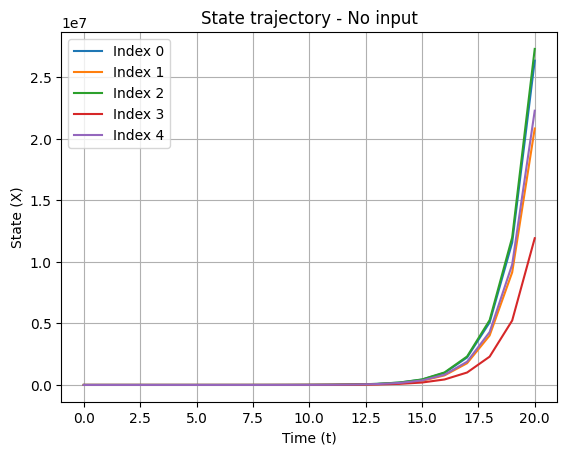

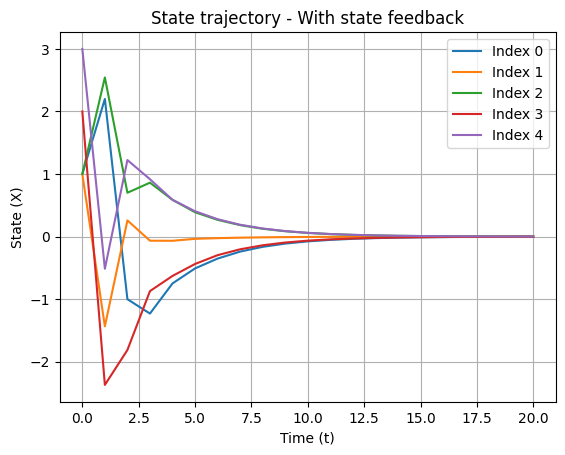

In [5]:
x0 = np.array([1.,1.,1.,2.,3.])
T = 20

n = A.shape[1]
m = B.shape[1]
Q = cp.Variable((n,n), symmetric=True)
Y = cp.Variable((m,n))

K = np.zeros((B.shape[1],B.shape[0]))
state(x0,A,B,K,T)
plt.title('State trajectory - No input')

plt.figure()
K = feedback_matrix(Q,Y,tol,None)
print('K = ',K)
state(x0,A,B,K,T)
plt.title('State trajectory - With state feedback')

In [6]:
print('Eigenvalues :',np.linalg.eigvals(A+B@K))
print('Absolute eigenvalues :',abs(np.linalg.eigvals(A+B@K)))

Eigenvalues : [ 0.68327324+0.j         -0.06078355+0.17214618j -0.06078355-0.17214618j
  0.07491129+0.j          0.01456528+0.j        ]
Absolute eigenvalues : [0.68327324 0.18256217 0.18256217 0.07491129 0.01456528]


## Distributed Control

We consider the control input $u_t \in \mathbb{R}^2$ as two local agents, each of which
controls one component of $u_t$. Suppose that the first agent can only access the first three elements
of $x_t$, and the second agent can access the last three elements of $x_t$.

Collectively, the controller gain matrix $K$ have the following sparsity pattern (where $\ast$ denotes a real number):

$$
K = 
\begin{bmatrix}
\ast & \ast & \ast & 0 & 0 & 0 \\
0 & 0 & \ast & \ast & \ast & \ast
\end{bmatrix}
$$


Size of problem :  124
Solver used :  CLARABEL
Is the solution optimal :  optimal
Time required by solver to setup the problem : None s
Number of iterations : 7
Time required by solver to solve the problem : 0.001046573 s
Optimal cost : 0.0
Optimal Q: <DIAgonal sparse matrix of dtype 'float64'
	with 5 stored elements (1 diagonals) and shape (5, 5)>
  Coords	Values
  (0, 0)	2.656942583397857
  (1, 1)	0.5804270918818638
  (2, 2)	1.4187754237586603
  (3, 3)	1.9396493648421336
  (4, 4)	0.7020586486026874
Optimal Y: [[-1.21483982e+00 -4.47551498e-01 -8.21530459e-02  1.01106245e-16
  -1.74017536e-16]
 [ 7.85486374e-16 -4.86466585e-16 -9.33595287e-01 -5.12941584e-01
  -6.11743617e-01]] 

K =  [[-4.57232246e-01 -7.71072723e-01 -5.79041930e-02  5.21260425e-17
  -2.47867520e-16]
 [ 2.95635434e-16 -8.38118329e-16 -6.58028939e-01 -2.64450675e-01
  -8.71356857e-01]]


Text(0.5, 1.0, 'State trajectory - Distributed control')

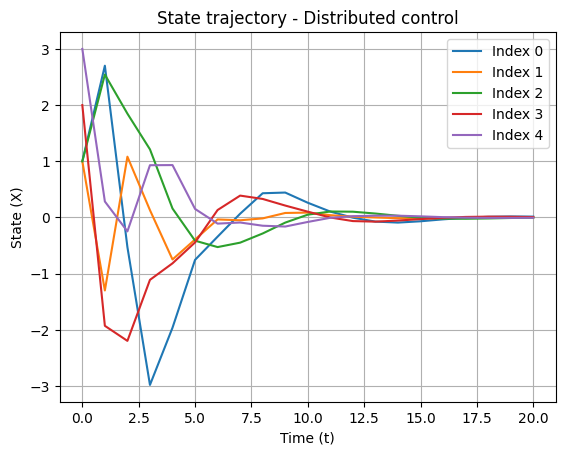

In [7]:
x0 = np.array([1.,1.,1.,2.,3.])
T = 20

n = A.shape[1]
m = B.shape[1]
Q = cp.Variable((n,n), diag=True)
Y = cp.Variable((m,n))

constraint = [Y[1,:2]==0,Y[0,-2:]==0]

K = feedback_matrix(Q,Y,tol,constraint)
print('K = ',K)
state(x0,A,B,K,T)
plt.title('State trajectory - Distributed control')

In [8]:
print('Eigenvalues :',np.linalg.eigvals(A+B@K))
print('Absolute eigenvalues :',abs(np.linalg.eigvals(A+B@K)))

Eigenvalues : [ 0.61731248+0.41346531j  0.61731248-0.41346531j -0.08313566+0.58428941j
 -0.08313566-0.58428941j -0.23763716+0.j        ]
Absolute eigenvalues : [0.74298604 0.74298604 0.59017426 0.59017426 0.23763716]


# SDP relaxations for binary quadratic optimization

Binary Quadratic optimization involves minimization of quadratic cost function with binary constraint.
$$
\begin{aligned}
\text{minimize} \quad & x^T Q x \\
\text{subject to} \quad & x_i \in \{-1, +1\}, \quad i = 1, \dots, n
\end{aligned}
$$

This optimization problem is **NP-Hard** and can be approximated using **Semi definite relaxation**
$$
\begin{aligned}
\text{minimize} \quad & \langle QX \rangle \\
\text{subject to} \quad & X_{ii} = 1, \quad i = 1, \dots, n \\
                        & X \succeq 0
\end{aligned}
$$

The dual of the SDP relaxation is:

$$
\begin{aligned}
\text{maximize} \quad & Tr(\Lambda) \\
\text{subject to}  \quad & Q - \Lambda \succeq 0 \\
& \Lambda \ \text{is diagonal}
\end{aligned}
$$

To extract the original vector $x \in \{-1,1\}^n$ from $X \in \mathbb{S}_n$, **randomized random process** is used. One of the famous technique is the **Geomans Williamson**

$$
\begin{aligned}
x_i &= sgn(\langle v_i,z \rangle)\\
\text{Where, } X = V^TV & \quad  and \quad z \text{ is a standard random Gaussian vector} \\
\text{The expected value of cost function} & \text{from Geomans Williamson rounding is}  \\
\mathbb{E}[x^TQx] &= Tr(Q) + \frac{2}{\pi} \sum_{i\neq j}Q_{ij}\sin^{-1}(X_{ij})\\
\end{aligned}

$$

In [33]:
n = 100
N_trial = 10000

def obj_random_sampling(Q,n_size = n,N = N_trial):
    obj_random = []
    x_best = np.zeros(n_size)
    obj_best = 1e10
    for i in range(N):
        x = np.sign(np.random.normal(0,1,n_size)) #np.random.choice([1, -1], size=n_size)
        obj_random.append(x.T@Q@x)
        if(obj_random[-1]<obj_best):
            obj_best = obj_random[-1]
            x_best = x

    plt.hist(obj_random,bins = 100, edgecolor='black',label='Naive')

    plt.title('Histogram of objective function - equal probability')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    print('Best x : ',x_best)
    print('Best objective : ',obj_best)
    print('Calculated expected value of objective :', np.trace(Q))
    print('Average objective : ',sum(obj_random)/len(obj_random),'\n')

    return plt

def SDP_relaxation(Q,n_size = n):

    X = cp.Variable((n_size,n_size))
    constraints = [X>>0]+ [X[i,i]==1 for i in range(n_size)]
    objective = cp.Minimize(cp.trace(Q.T@X))      
    
    problem = cp.Problem(objective, constraints) # Define the problem

    init =time.time()
    problem.solve(solver=cp.SCS) # Solve the problem
    final = time.time()
    
    print('Size of problem : ', problem.size_metrics.num_scalar_data)
    print('Solver used : ',problem.solver_stats.solver_name) 
    print("Is the solution optimal : ", problem.status)   
    print('Time required by solver to setup the problem :',problem.solver_stats.setup_time,'s')
    print('Number of iterations :',problem.solver_stats.num_iters)
    print('Time required by solver to solve the problem :',problem.solver_stats.solve_time,'s')
    print("Optimal cost :", problem.value)
    # print("Optimal X:", X.value,'\n')
    return X.value

def SDP_relaxation_dual(Q,n_size = n):

    X = cp.Variable((n_size,n_size),diag=True)
    constraints = [(Q-X)>>0]
    objective = cp.Maximize(cp.trace(X))      
    
    problem = cp.Problem(objective, constraints) # Define the problem

    init =time.time()
    problem.solve(solver=cp.SCS) # Solve the problem
    final = time.time()
    
    print('Size of problem : ', problem.size_metrics.num_scalar_data)
    print('Solver used : ',problem.solver_stats.solver_name) 
    print("Is the solution optimal : ", problem.status)   
    print('Time required by solver to setup the problem :',problem.solver_stats.setup_time,'s')
    print('Number of iterations :',problem.solver_stats.num_iters)
    print('Time required by solver to solve the problem :',problem.solver_stats.solve_time,'s')
    print("Optimal value (Optimal Lower bound of the primal problem) :", problem.value)

def geomans_willamson(X,Q,plt,n_size = n,N = N_trial):
    
    mu = 0
    sigma = 1
    U,S,Vh = np.linalg.svd(X)
    W = np.diag(np.sqrt(S))@Vh
    
    obj_random = []
    x_best = np.zeros(n_size)
    obj_best = 1e10

    for i in range(N):
        z = np.random.normal(mu,sigma,n)
        x = np.sign(W.T@z)
        obj_random.append(x.T@Q@x)
        if(obj_random[-1]<obj_best):
            obj_best = obj_random[-1]
            x_best = x
    
    plt.hist(obj_random,bins = 100, edgecolor='black',label='GW')

    plt.title('Histogram of objective function')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    print('Best x : ',x_best)
    print('Best objective : ',obj_best)

    # Expected value
    print('Maximum value of X:',np.max(X))
    print('Minimum value of X:',np.min(X))
    X = np.clip(X,-1,1)                         # To avoid error during sin inverse
    obj_exp_geo_will = (2/np.pi)*np.sum(Q*np.arcsin(X))
    print('Calculated expected value of objective : ',obj_exp_geo_will)
    print('Average objective : ',sum(obj_random)/len(obj_random))

Naive random selection

Best x :  [ 1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1.
 -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.
  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1.
 -1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.  1.  1. -1.  1.
  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.
  1. -1. -1.  1. -1. -1. -1.  1. -1. -1.]
Best objective :  -744.7755369977803
Calculated expected value of objective : 19.113887440308837
Average objective :  19.210100100139453 

Size of problem :  10101
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.008254854 s
Number of iterations : 325
Time required by solver to solve the problem : 0.52577863 s
Optimal cost : -2349.554292874226

Geomans Willamson selection

Best x :  [ 1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1. -1.  1.
  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -

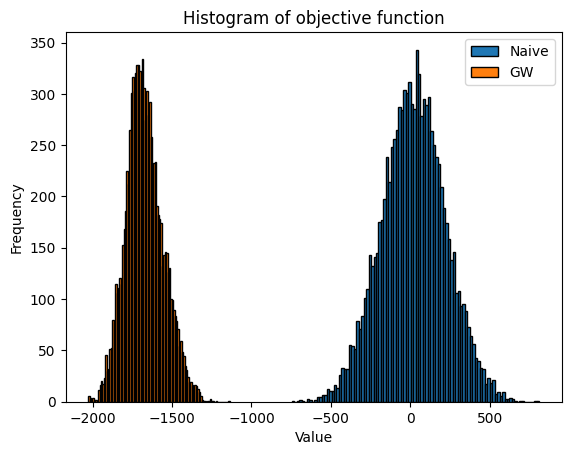

In [10]:
mat_test = scipy.io.loadmat('Q.mat')
Q_test = mat_test['Q']

print ('Naive random selection\n')
plt = obj_random_sampling(Q_test)
X =  SDP_relaxation(Q_test)
print ('\nGeomans Willamson selection\n')
geomans_willamson(X,Q_test,plt)

In [11]:
Q = np.random.randn(n,n)
Q = Q+Q.T
Q = Q/np.max(np.linalg.eigvals(Q))  # For scaling to reduce the magnitude of objective for comparison

np.linalg.eigvals(Q)

array([ 1.        ,  0.99012324,  0.88763996,  0.87114883, -0.9640384 ,
       -0.95482045, -0.9164978 , -0.87158623, -0.85736301, -0.81096621,
        0.7968011 ,  0.77995942,  0.76965097, -0.76791062, -0.75626035,
        0.75157551,  0.73495814, -0.72468079, -0.70943551,  0.69070991,
       -0.67902535,  0.66495833, -0.66116674,  0.65121724, -0.63630098,
       -0.61473039, -0.61052811,  0.61363095,  0.61169571, -0.59196584,
        0.58309741,  0.5757205 , -0.56752178, -0.54728297, -0.53991822,
        0.54033051,  0.51467946,  0.50554095,  0.50200217, -0.49748779,
       -0.50180825,  0.4780627 ,  0.46543752, -0.46696421,  0.44490992,
        0.43172763,  0.41487712,  0.40363187, -0.41927389, -0.42660484,
       -0.40543427, -0.38933088, -0.40138989,  0.38658096,  0.37050636,
        0.35457976, -0.34706897,  0.33150488,  0.32300098,  0.30917431,
       -0.33524   , -0.32441129, -0.3079999 , -0.29352819,  0.27970535,
        0.26256238, -0.27739034, -0.26104333,  0.24343622, -0.23

Naive random selection

Best x :  [-1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1.
 -1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.
  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.
 -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1.
 -1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
 -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.]
Best objective :  -27.414674893895675
Calculated expected value of objective : -0.2374211177736788
Average objective :  -0.2804014886722935 

Size of problem :  10101
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.005876805 s
Number of iterations : 125
Time required by solver to solve the problem : 0.210208632 s
Optimal cost : -86.7819422199514

Geomans Willamson selection

Best x :  [-1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1.
 -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1

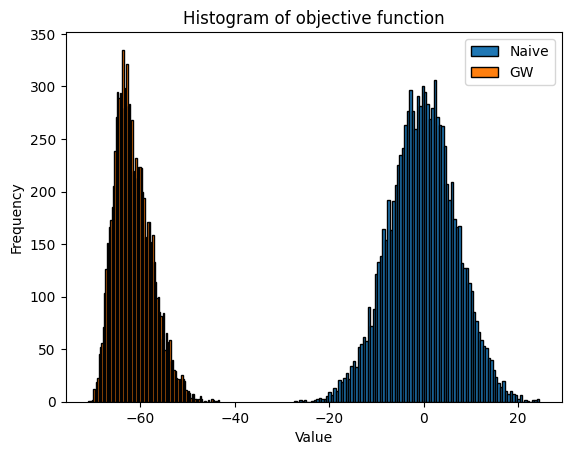

In [12]:
print ('Naive random selection\n')
plt = obj_random_sampling(Q)
X =  SDP_relaxation(Q)
print ('\nGeomans Willamson selection\n')
geomans_willamson(X,Q,plt)

In [13]:
SDP_relaxation_dual(Q)

Size of problem :  10001
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.000868668 s
Number of iterations : 225
Time required by solver to solve the problem : 0.356946463 s
Optimal value (Optimal Lower bound of the primal problem) : -86.78162212553589


## Q - sampled from poisson distribution

In [40]:
Q = np.random.poisson(lam=1,size=(n,n))
Q = Q+Q.T
Q = Q/np.max(np.linalg.eigvals(Q))  # For scaling to reduce the magnitude of objective for comparison
np.linalg.eigvals(Q)

array([ 1.00000000e+00, -1.35417611e-01, -1.31459089e-01, -1.28764624e-01,
       -1.24975825e-01, -1.17728795e-01,  1.28044611e-01,  1.24710697e-01,
        1.22211097e-01,  1.18653564e-01,  1.16136538e-01,  1.12408775e-01,
       -1.12922438e-01, -1.06748401e-01,  1.08653302e-01, -1.02841213e-01,
        1.02896759e-01,  9.88359456e-02, -9.85603204e-02,  9.37386124e-02,
       -9.69898313e-02, -9.35405468e-02, -9.22437734e-02,  9.11182903e-02,
        8.99970852e-02, -8.91856558e-02, -8.73806013e-02,  8.60888565e-02,
       -8.30630619e-02,  8.49153932e-02, -8.03651199e-02, -7.83368984e-02,
        8.16330652e-02,  7.80697630e-02, -7.44841582e-02, -7.27830244e-02,
        7.58425330e-02,  7.25899392e-02,  7.36256598e-02,  7.04822385e-02,
       -6.98129898e-02, -6.73057750e-02, -6.50146648e-02,  6.66351420e-02,
        6.42790099e-02,  6.34405344e-02, -5.89888811e-02,  5.97321284e-02,
       -5.70790829e-02,  5.78665142e-02, -5.79240640e-02,  5.62296996e-02,
        5.48831046e-02,  

Naive random selection

Best x :  [-1. -1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.
  1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1.
 -1.  1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.]
Best objective :  -3.3401457615084205
Calculated expected value of objective : 1.0431686462368641
Average objective :  1.0435979502566604 

Size of problem :  10101
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.010543917 s
Number of iterations : 300
Time required by solver to solve the problem : 1.3898758290000002 s
Optimal cost : -12.082696147189449

Geomans Willamson selection

Best x :  [ 1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.
 -1.  1. -1.  1.  1.  1. -1.  1.  1.

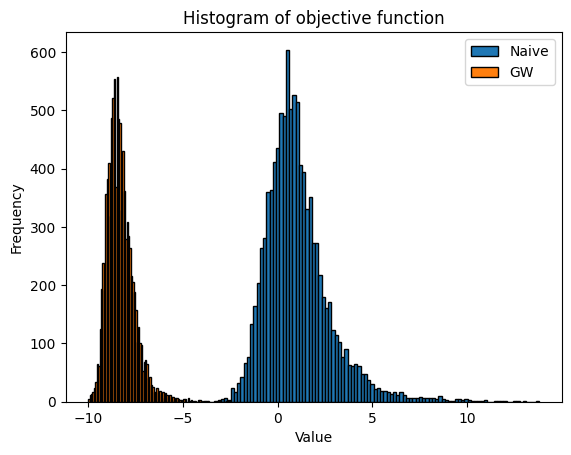

In [41]:
print ('Naive random selection\n')
plt = obj_random_sampling(Q)
X =  SDP_relaxation(Q)
print ('\nGeomans Willamson selection\n')
geomans_willamson(X,Q,plt)

For poisson distribution, the sampling gave slightly skew distribution

## Q - Sparse matrix

In [16]:
Q = scipy.sparse.random(n, n, density=0.3).toarray()
Q = Q+Q.T
Q = Q/np.max(np.linalg.eigvals(Q))  # For scaling to reduce the magnitude of objective for comparison
print(Q)

[[0.         0.         0.01644732 ... 0.         0.00343162 0.        ]
 [0.         0.03943972 0.         ... 0.         0.         0.02525157]
 [0.01644732 0.         0.01135508 ... 0.05895428 0.00292117 0.00868304]
 ...
 [0.         0.         0.05895428 ... 0.         0.01439306 0.        ]
 [0.00343162 0.         0.00292117 ... 0.01439306 0.         0.        ]
 [0.         0.02525157 0.00868304 ... 0.         0.         0.02072408]]


Naive random selection

Best x :  [ 1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.
 -1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1.
 -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.
 -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.
 -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.]
Best objective :  -6.389275277762773
Calculated expected value of objective : 0.7000953148004349
Average objective :  0.7014113090857891 

Size of problem :  10101
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.006312571 s
Number of iterations : 250
Time required by solver to solve the problem : 0.406193817 s
Optimal cost : -22.20861670123385

Geomans Willamson selection

Best x :  [ 1.  1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1. -1.
  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1. 

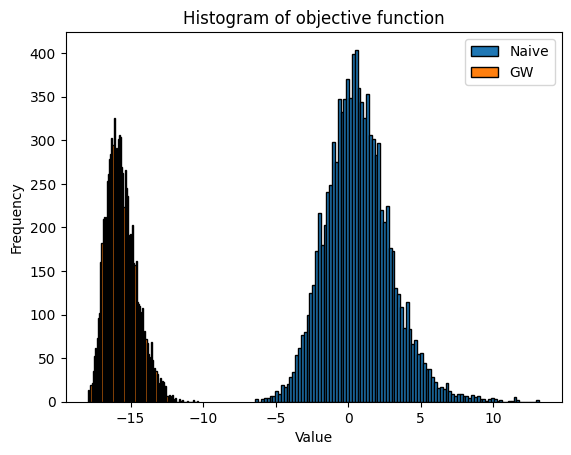

In [17]:
print ('Naive random selection\n')
plt = obj_random_sampling(Q)
X =  SDP_relaxation(Q)
print ('\nGeomans Willamson selection\n')
geomans_willamson(X,Q,plt)

The naive randomization scheme performance is not good in the case of sparse matrices. 

## Q - Low Rank matrix

In [38]:
r = int(n*np.random.rand())
print(r)
A = np.random.randn(n,r)
B = np.random.randn(r,n)
Q = A@B
Q = Q+Q.T
Q = Q/np.max(abs(np.linalg.eigvals(Q)))  # For scaling to reduce the magnitude of objective for comparison
abs(np.linalg.eigvals(Q))

7


array([1.00000000e+00, 8.34135283e-01, 7.27626826e-01, 6.21470124e-01,
       6.81604154e-01, 5.82726179e-01, 5.15646826e-01, 4.70433976e-01,
       5.66573276e-01, 5.04774900e-01, 4.32687940e-01, 3.76518468e-01,
       3.92576878e-01, 3.99922176e-01, 7.15890766e-17, 8.34480306e-17,
       6.17411932e-17, 6.17411932e-17, 5.77299411e-17, 5.77299411e-17,
       5.68656156e-17, 5.68656156e-17, 5.62827991e-17, 4.94862497e-17,
       4.94862497e-17, 5.17713284e-17, 4.82840006e-17, 4.82840006e-17,
       5.10753679e-17, 5.10753679e-17, 4.84853721e-17, 4.84853721e-17,
       4.88312086e-17, 4.88312086e-17, 4.29180139e-17, 4.29180139e-17,
       4.10790229e-17, 4.10790229e-17, 4.11927594e-17, 3.94363093e-17,
       3.94363093e-17, 3.96110036e-17, 3.96110036e-17, 3.78368893e-17,
       3.78368893e-17, 3.84202960e-17, 3.84202960e-17, 3.60849324e-17,
       3.60849324e-17, 3.59224968e-17, 3.59224968e-17, 3.64003165e-17,
       3.64003165e-17, 3.27935733e-17, 3.27935733e-17, 3.08890851e-17,
      

Naive random selection

Best x :  [ 1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.
  1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
  1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.]
Best objective :  -17.434538616786153
Calculated expected value of objective : 0.17326150771344392
Average objective :  0.09678841417385127 

Size of problem :  10101
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.017978357 s
Number of iterations : 150
Time required by solver to solve the problem : 0.734244114 s
Optimal cost : -70.3740173790593

Geomans Willamson selection

Best x :  [-1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1

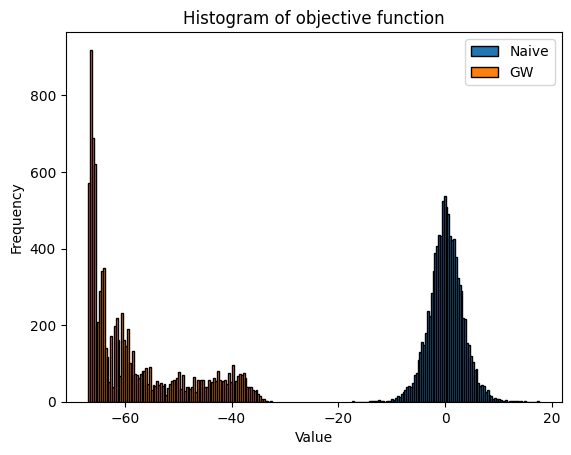

In [39]:
print ('Naive random selection\n')
plt = obj_random_sampling(Q)
X =  SDP_relaxation(Q)
print ('\nGeomans Willamson selection\n')
geomans_willamson(X,Q,plt)

In low rank matrices, the Geoman distribution exhibits non gaussian or mixture of gaussian behavior

## Q - Positive semi definite matrix

In [20]:
r = int(n*np.random.rand())
print(r)
A = np.random.randn(r,n)
Q = A.T@A   # xTATAx = ||Ax||^2>=0
Q = Q/np.max(abs(np.linalg.eigvals(Q)))  # For scaling to reduce the magnitude of objective for comparison
abs(np.linalg.eigvals(Q))

71


array([1.00000000e+00, 9.21327057e-01, 8.98666517e-01, 8.79527310e-01,
       8.39819285e-01, 8.28225428e-01, 7.93227936e-01, 7.54917932e-01,
       7.30164764e-01, 6.88530714e-01, 6.63675459e-01, 6.53470786e-01,
       6.15885226e-01, 5.88960397e-01, 5.71143782e-01, 5.54860882e-01,
       5.24364889e-01, 4.93371060e-01, 4.68819757e-01, 4.52636178e-01,
       4.27310688e-01, 4.17590588e-01, 4.09496128e-01, 3.93661753e-01,
       3.77549052e-01, 3.69414176e-01, 3.44326768e-01, 3.13548686e-01,
       3.08959552e-01, 2.94684424e-01, 2.95298362e-01, 2.75437175e-01,
       2.71276209e-01, 2.59268051e-01, 2.45915774e-01, 2.33413123e-01,
       2.20828117e-01, 2.14589932e-01, 2.05062404e-01, 1.90684098e-01,
       1.83700613e-01, 1.75768792e-01, 1.68323524e-01, 1.34135335e-01,
       1.36474840e-01, 1.45065973e-01, 1.49722472e-01, 1.09739371e-01,
       1.15543247e-01, 1.50337711e-01, 9.95703621e-02, 8.74141882e-02,
       9.24940646e-02, 1.04562613e-02, 8.08783276e-02, 9.54158736e-02,
      

Naive random selection

Best x :  [ 1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.
 -1. -1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.
  1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.
  1. -1. -1. -1.  1. -1.  1.  1.  1. -1.]
Best objective :  11.132783247818999
Calculated expected value of objective : 22.563430876478183
Average objective :  22.520321016070255 

Size of problem :  10101
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.006805563000000001 s
Number of iterations : 150
Time required by solver to solve the problem : 0.244867402 s
Optimal cost : -2.3055746127873474e-06

Geomans Willamson selection

Best x :  [-1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1.
  1.  1.  1. -1. -1. -1.  1. -1

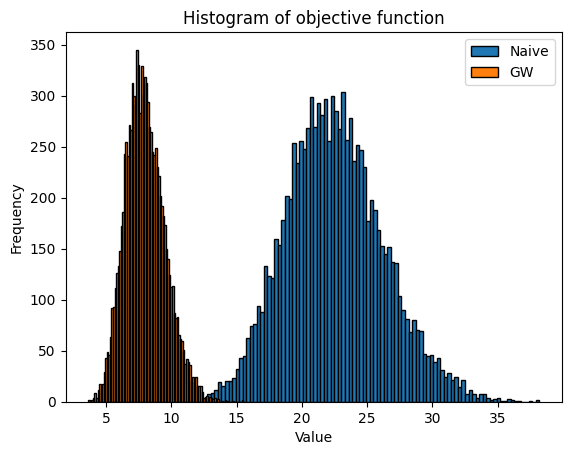

In [21]:
print ('Naive random selection\n')
plt = obj_random_sampling(Q)
X =  SDP_relaxation(Q)
print ('\nGeomans Willamson selection\n')
geomans_willamson(X,Q,plt)

For positive semi definite matrices, random initialization and Williamson rounding are the closest.

# Nuclear and Spectral norm using SDP

The **nuclear norm** of a matrix $A \in \mathbb{R}^{m \times n}$ is given by:

$$
\|A\|_* = \sum_{i=1}^{\min\{m, n\}} \sigma_i(A),
$$

where $\sigma_i(A)$ is the $i$-th singular value of $A$. Given the spectral norm $\| \cdot \|$ for matrices in $\mathbb{R}^{m \times n}$, the **dual norm** is defined as:

$$
\|X\|_d = \max_{Y \in \mathbb{R}^{m \times n}} \ \langle X, Y \rangle \quad \text{subject to} \quad \|Y\| \leq 1
$$

For the spectral norm $\|A\| = \sigma_{\max}(A)$, we have the following equivalence:

$$
\|A\| \leq t
\quad \Leftrightarrow \quad
\lambda_{\max}(A^T A) \leq t^2
\quad \Leftrightarrow \quad
\lambda_{\max}(A^T A - t^2I_n)\leq 0
\quad \Leftrightarrow \quad
t^2 I_n - A^T A \succeq 0
$$


The primal SDP problem becomes 

$$

\begin{aligned}
\|X\|_d = \text{maximize} \quad & \langle X, Y \rangle \\
\text{subject to} \quad & I_n - A^T A \succeq 0
\end{aligned}
$$

In [22]:
def Solver(objective,constraints):
    problem = cp.Problem(objective, constraints) # Define the problem

    init =time.time()
    problem.solve(solver=cp.SCS) # Solve the problem
    final = time.time()
    
    print('Size of problem : ', problem.size_metrics.num_scalar_data)
    print('Solver used : ',problem.solver_stats.solver_name) 
    print("Is the solution optimal : ", problem.status)   
    print('Time required by solver to setup the problem :',problem.solver_stats.setup_time,'s')
    print('Number of iterations :',problem.solver_stats.num_iters)
    print('Time required by solver to solve the problem :',problem.solver_stats.solve_time,'s')
    # print("Optimal cost :", problem.value)
    # print("Optimal X:", X.value,'\n')
    return problem.value

In [23]:
def SDP_nuclear_norm(X):
# This is written using the fact that nuclear norm is DUAL NORM of spectral norm  

   Y = cp.Variable(X.shape)
   #constraint = [np.eye(Y.shape[1])-Y.T@Y>>0]
   objective = cp.Maximize(cp.trace(X.T@Y))

   top_left = np.eye(Y.shape[0]) 
   top_right = Y
   bottom_left = Y.T
   bottom_right = np.eye(Y.shape[1])

   T = cp.bmat([[top_left, top_right],
               [bottom_left, bottom_right]])

   constraint = [T>>0]
   return Y,objective, constraint

def SDP_spectral_norm(X):
# This is written using the fact that spectal norm inequality ||A||<t can be wriiten as semidefinite contraint. We can minimize the upper bound t to get actual value 

   t = cp.Variable()
   # constraint = [(t**2)*np.eye(X.shape[1])-X.T@X>>0]

   objective = cp.Minimize(t)
   top_left = t*np.eye(X.shape[0]) 
   top_right = X
   bottom_left = X.T
   bottom_right = t*np.eye(X.shape[1])

   T = cp.bmat([[top_left, top_right],
    [bottom_left, bottom_right]])

   constraint = [T>>0]
   return t,objective, constraint

In [24]:
n = data.shape[0]
for i in range(n):
    content = data[i][0][0][0]
    A = content[0]
    print('Nuclear norm (SDP) for matrix ',i+1,'\n')
    init = time.time()
    Y, obj, const = SDP_nuclear_norm(A)
    sol = Solver(obj,const)
    final = time.time()
    print('Total time required',final-init,'\n') 
    print('NUCLEAR NORM : ',sol,'\n') 

Nuclear norm (SDP) for matrix  1 

Size of problem :  176
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 7.1604e-05 s
Number of iterations : 50
Time required by solver to solve the problem : 0.00072049 s
Total time required 0.00482487678527832 

NUCLEAR NORM :  7.048030557015974 

Nuclear norm (SDP) for matrix  2 

Size of problem :  4376
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.001024751 s
Number of iterations : 75
Time required by solver to solve the problem : 0.034458219 s
Total time required 0.041632652282714844 

NUCLEAR NORM :  64.10633879295088 

Nuclear norm (SDP) for matrix  3 

Size of problem :  17501
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.003953959 s
Number of iterations : 100
Time required by solver to solve the problem : 0.252649095 s
Total time required 0.28426313400268555 

NUCLEAR NORM :  167

In [25]:
i = 0
n = data.shape[0]
for i in range(n):
    content = data[i][0][0][0]
    A = content[0]
    print('Spectral norm (SDP) for matrix ',i+1,'\n')
    init = time.time()
    Y, obj, const = SDP_spectral_norm(A)
    sol = Solver(obj,const)
    final = time.time()
    print('Total time required',final-init,'\n')
    print('SPECTRAL NORM : ',sol,'\n')  

Spectral norm (SDP) for matrix  1 

Size of problem :  226
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 5.7648e-05 s
Number of iterations : 300
Time required by solver to solve the problem : 0.011038952999999999 s
Total time required 0.016970396041870117 

SPECTRAL NORM :  3.6198762867807437 

Spectral norm (SDP) for matrix  2 

Size of problem :  5626
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.000591107 s
Number of iterations : 125
Time required by solver to solve the problem : 0.092538039 s
Total time required 0.09952521324157715 

SPECTRAL NORM :  18.11744830340894 

Spectral norm (SDP) for matrix  3 

Size of problem :  22501
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.001813949 s
Number of iterations : 350
Time required by solver to solve the problem : 1.3881002859999998 s
Total time required 1.39782190322875

In [26]:
i = 0
n = data.shape[0]
for i in range(n):
    content = data[i][0][0][0]
    A = content[0]
    init = time.time()
    U,S,Vh = np.linalg.svd(A)
    spectral_norm = max(S)
    nuclear_norm = np.sum(S)
    final = time.time()
    print('Spectral norm (SVD) for matrix ',i+1,':',spectral_norm)
    print('Nuclear norm (SVD) for matrix ',i+1,':',nuclear_norm)
    print('Total time required',final-init,'\n') 

Spectral norm (SVD) for matrix  1 : 3.619869714392037
Nuclear norm (SVD) for matrix  1 : 7.048029332967689
Total time required 0.00021696090698242188 

Spectral norm (SVD) for matrix  2 : 18.11749192565098
Nuclear norm (SVD) for matrix  2 : 64.10633187430552
Total time required 0.00036406517028808594 

Spectral norm (SVD) for matrix  3 : 35.07413631514383
Nuclear norm (SVD) for matrix  3 : 167.4988164796404
Total time required 0.04175853729248047 

Spectral norm (SVD) for matrix  4 : 53.558864814288455
Nuclear norm (SVD) for matrix  4 : 294.78680927038494
Total time required 0.32397031784057617 

Spectral norm (SVD) for matrix  5 : 70.38190250519403
Nuclear norm (SVD) for matrix  5 : 447.8563780768072
Total time required 0.9279239177703857 



# Feasible Region for 2x2 Symmetric Matrix with nuclear and spectral norm

In [27]:
# Create grid for 3 off-diagonal elements
a = np.linspace(-1, 1, 100)
b = np.linspace(-1, 1, 100)
c = np.linspace(-1, 1, 100)
A, B, C = np.meshgrid(a, b, c)

feasible_points_nuc_norm = []
feasible_points_spc_norm = []

for i in range(len(a)):
    for j in range(len(b)):
        for k in range(len(c)):
            # Create symmetric matrix
            matrix = np.array([[A[i,j,k], B[i,j,k]],
                             [B[i,j,k],C[i,j,k]]])
            
            # Check for less than one condition
            singular_val= abs(np.linalg.eigvals(matrix))
            if np.sum(singular_val) <= 1:
                feasible_points_nuc_norm.append([A[i,j,k], B[i,j,k], C[i,j,k]])
            if np.max(singular_val) <= 1:
                feasible_points_spc_norm.append([A[i,j,k], B[i,j,k], C[i,j,k]])

feasible_points_nuc_norm = np.array(feasible_points_nuc_norm)
feasible_points_spc_norm = np.array(feasible_points_spc_norm)

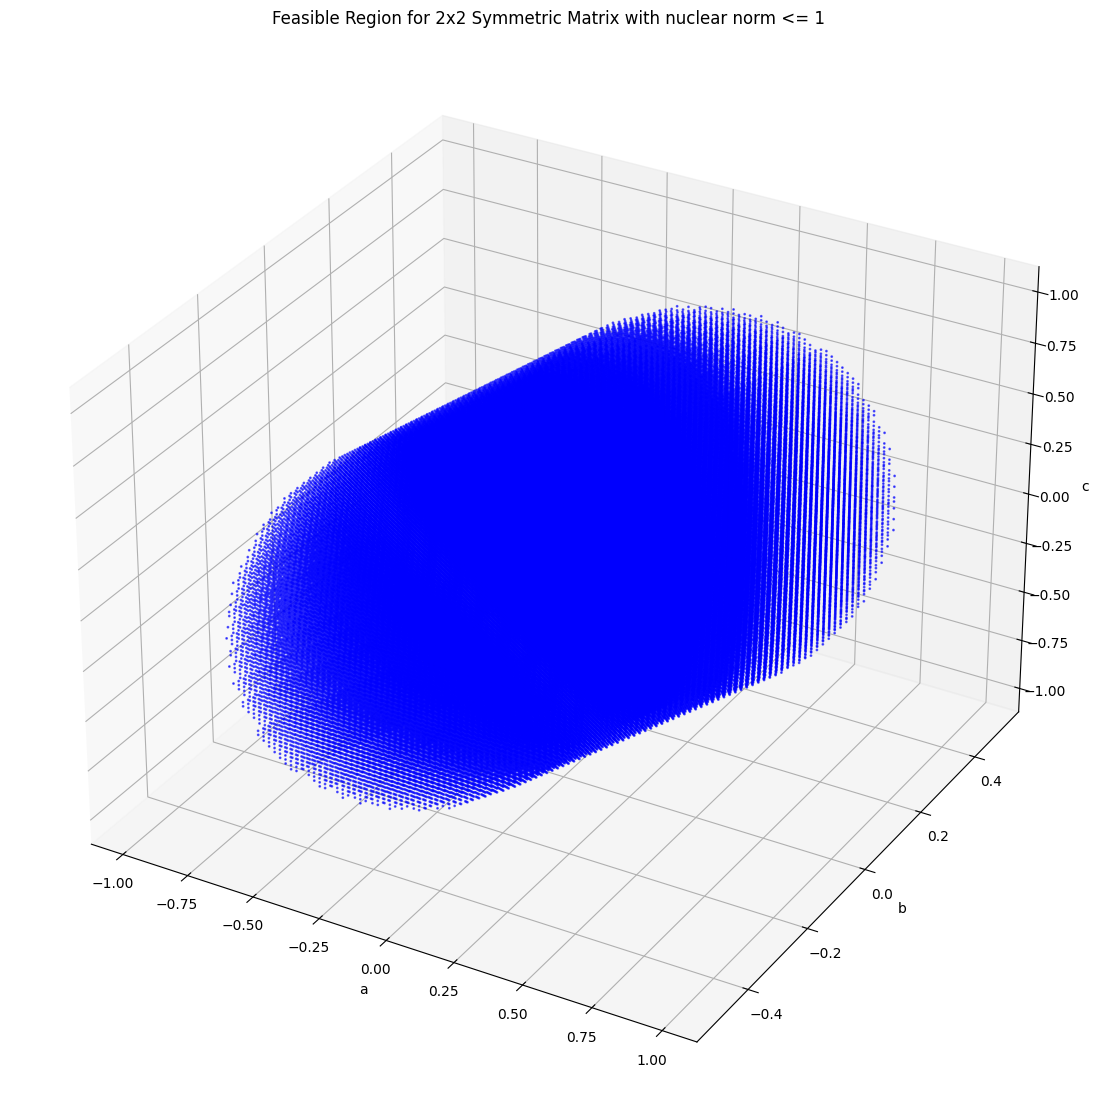

In [28]:
# 3D Plot nuclear norm

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feasible_points_nuc_norm[:,0], feasible_points_nuc_norm[:,1], feasible_points_nuc_norm[:,2], 
          c='b', alpha=0.6, s=1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c')
ax.set_title('Feasible Region for 2x2 Symmetric Matrix with nuclear norm <= 1')
plt.show()

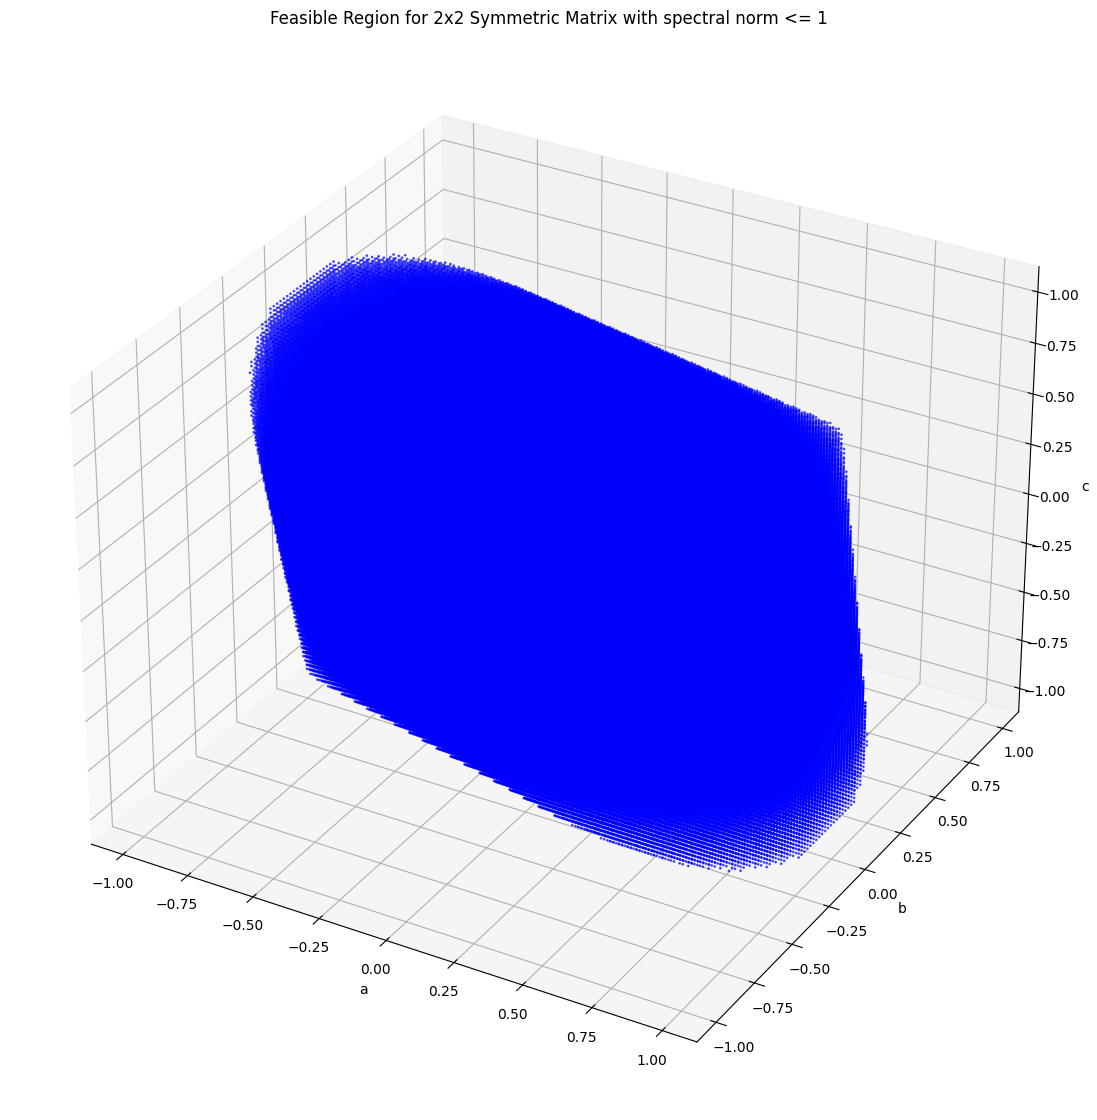

In [29]:
# 3D Plot spectral norm
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feasible_points_spc_norm[:,0], feasible_points_spc_norm[:,1], feasible_points_spc_norm[:,2], 
          c='b', alpha=0.6, s=1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c')
ax.set_title('Feasible Region for 2x2 Symmetric Matrix with spectral norm <= 1')
plt.show()